### This is an R2OpenBUGS program for the artificial example in Chapter 4, Section 4.5.

Model: Standard Structural Equation Model
Data Set Name: YO.dat
Sample Size: N=300

In [1]:
source(".Rprofile")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: coda

Loading required package: boot

This is cmdstanr version 0.6.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/pal_bjartan/.cmdstan/cmdstan-2.33.1

- CmdStan version: 2.33.1

This is bayesplot version 1.10.0

- Online documentation and 



#### (A) Codes for specification of the model using R language

In [45]:
model.code  <- function() {
    for(i in 1:N){
        #measurement equation model
        for(j in 1:P){
            y[i,j] ~ dnorm(mu[i,j],psi[j])
            ephat[i,j] <- y[i,j] - mu[i,j]
        }
        mu[i,1] <- eta[i]+alp[1]
        mu[i,2] <- lam[1] * eta[i] + alp[2]
        mu[i,3] <- lam[2] * eta[i] + alp[3]
        mu[i,4] <- xi[i,1] + alp[4]
        mu[i,5] <- lam[3] * xi[i,1] + alp[5]
        mu[i,6] <- lam[4] * xi[i,1] + alp[6]
        mu[i,7] <- xi[i,2] + alp[7]
        mu[i,8] <- lam[5] * xi[i,2] + alp[8]
        mu[i,9] <- lam[6] * xi[i,2] + alp[9]

        #structural equation model
        xi[i,1:2] ~ dmnorm(u[1:2], phi[1:2,1:2])
        eta[i] ~ dnorm(nu[i], psd)
        nu[i] <- gam[1] * xi[i,1] + gam[2] * xi[i,2]
        dthat[i] <- eta[i] - nu[i]
    } #end of i

    #priors on intercepts
    for(j in 1:9){alp[j]~dnorm(0.0, 1.0)}

    #priors on loadings and coefficients
    lam[1] ~ dnorm(0.8, psi[2])
    lam[2] ~ dnorm(0.8, psi[3])
    lam[3] ~ dnorm(0.8, psi[5])
    lam[4] ~ dnorm(0.8, psi[6])
    lam[5] ~ dnorm(0.8, psi[8])
    lam[6] ~ dnorm(0.8, psi[9])
    for(j in 1:2){ gam[j] ~ dnorm(0.5, psd) }
    
    #priors on precisions
    for(j in 1:P){
        psi[j] ~ dgamma(9.0, 4.0)
        sgm[j] <- 1/psi[j]
    }
    psd ~ dgamma(9.0, 4.0)
    sgd <- 1/psd
    phi[1:2,1:2] ~ dwish(R[1:2,1:2], 5)
    phx[1:2,1:2] <- inverse(phi[1:2, 1:2])

} #end of model

write.model(model.code, con = "./Chapter4/ch4-R2OpenBUGS-model.txt")
model <- paste0(getwd(), "/Chapter4/ch4-R2OpenBUGS-model.txt")

#### (B) Check model

`bugs()` will autmatically check if model is syntactically correct. If
there are no errors, then the message *"model is syntactically correct"* will be printed in `log.txt` in the session's `tempdir()` or the directory defined in the `bugs()` function's `working.directory` argument.

#### (C) Load data

Read in dataset and save data object in the following format:

In [3]:
# Read in dataset as unnamed matrix
ch4.dat <- read.csv("./Chapter4/ch4-WinBUGS-data.dat", header = FALSE, skip = 2)[,1:9] %>% 
as.matrix()  %>% 
unname()

# Save data as list in the following format
data <- list(
   N = 300,
   P = 9,
   u = c(0,0),
   y = ch4.dat,
   R = structure(
      .Data=c( 1.0, 0.0,
               0.0, 1.0),
      .Dim = c(2,2))
)

The data will be loaded by `bugs()`' first argument `data`. When the data have been successfully loaded, the message *"data loaded"* should appear in the log file.

#### (D) Compile model

By default, `bugs()` simulate three chains of observations with three different sets of initial values (`n.chains = 3`). To change to a different number of Markov chains, add a different value to the `n.chains` argument. For this example the author used three chains, and the parameter can be left unchanged.

`bugs()` automatically compiles the model. If successful, the message "model
compiled" should appear in the log file.


#### (E) Load initial values

Initial values is stored as a function without input, which will be entered as `bugs()` second argument:

In [49]:
# Three different initial values
inits <- function() {
   list(alp = c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
      lam = c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
      psi = c(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0),
      psd = 1.0,
      gam = c(1.0, 1.0),
      phi = structure(
         .Data = c(  0.2, 0.1,
                     0.1, 0.9),
         .Dim = c(2,2)
      )
   )

   list(alp = c(-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0),
      lam = c(-1.0, 0.0, 0.3, 0.6, 0.9, 1.0),
      psi = c(1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5),
      psd = 1.5,
      gam = c(-1.0,-1.0),
      phi = structure(
         .Data = c(  0.5, 0.2,
                     0.2, 0.6),
         .Dim = c(2,2)
      )
   )

   list(alp = c(2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0),
      lam = c(1.0, 0.3, 0.4, 0.5, 1.0, -1.0),
      psi = c(0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3),
      psd = 0.3,
      gam = c(2.0, 2.0),
      phi = structure(
         .Data = c(  0.9, 0.3,
                     0.3, 0.8),
         .Dim = c(2,2)
      )
   )
}

This is necessary to generate the nodes `xi`'s in the MCMC algorithm.
If the model is fully initialized after loading the initial values, then a message
saying *"initial values loaded: model initialized'* will appear in the log file. Otherwise, the message *"initial values loaded: model contains uninitialized nodes"* will appear.

#### (F) Run simulation and check convergence

##### **Step 1: Input the monitored parameters**

`bugs()` third argument, `parameters.to.save`, stores the parameters to be
monitored as a character vector:

In [5]:
param <- c("alp", "lam", "psi", "phi", "gam", "xi")

##### **Step 2: Sample observations for the monitored node**

`bugs()`fourth argument, `n.iter`, stores the total number of MCMC iterations (for example, 5000 or 10000; the default value is 2000).

In [6]:
iter <- 5000

The argument `n.thin` sets the thinning rate (for example, k, i.e., the samples from every k-th iteration can be stored) into the box marked thin. The default is 1.

When the run finishes, the message `updates took ***s' will appear in the log file.

##### **Step 3: Check convergence**

The first few thousand iterations should be treated as burn-in iterations.
This is carried out by specifying the number in the `n.burnin` argument. The remaining iteration will be used to obtain the Bayesian statistics.

In [7]:
burnin  <- 2000

In order to check whether the algorithm has converged:
 1. Run `bugs()` with the parameter `codaPkg = TRUE`. File names of OpenBUGS output are then returned for easy access by the coda package through the `read.bugs()` function.
 2. Plot coda output files (e.g. using `plot()`) to show the simulated observations against the number of iterations for all of the defined parameters in the `parameters.to.save` argument.

In [1]:
model.out <- bugs(
    data, 
    inits, 
    param[-6], 
    model.file = model, 
    iter, 
    n.burnin = burnin, 
    codaPkg = TRUE,
    working.directory = paste0(getwd(), "/Chapter4/bugs-output")
)


ERROR: Error in bugs(data, inits, param[-6], model.file = model, n.iter, n.burnin = n.burnin, : could not find function "bugs"


Abstracting alp[1] ... 3000 valid values
Abstracting alp[2] ... 3000 valid values
Abstracting alp[3] ... 3000 valid values
Abstracting alp[4] ... 3000 valid values
Abstracting alp[5] ... 3000 valid values
Abstracting alp[6] ... 3000 valid values
Abstracting alp[7] ... 3000 valid values
Abstracting alp[8] ... 3000 valid values
Abstracting alp[9] ... 3000 valid values
Abstracting deviance ... 3000 valid values
Abstracting gam[1] ... 3000 valid values
Abstracting gam[2] ... 3000 valid values
Abstracting lam[1] ... 3000 valid values
Abstracting lam[2] ... 3000 valid values
Abstracting lam[3] ... 3000 valid values
Abstracting lam[4] ... 3000 valid values
Abstracting lam[5] ... 3000 valid values
Abstracting lam[6] ... 3000 valid values
Abstracting phi[1,1] ... 3000 valid values
Abstracting phi[1,2] ... 3000 valid values
Abstracting phi[2,1] ... 3000 valid values
Abstracting phi[2,2] ... 3000 valid values
Abstracting psi[1] ... 3000 valid values
Abstracting psi[2] ... 3000 valid values
Abstra

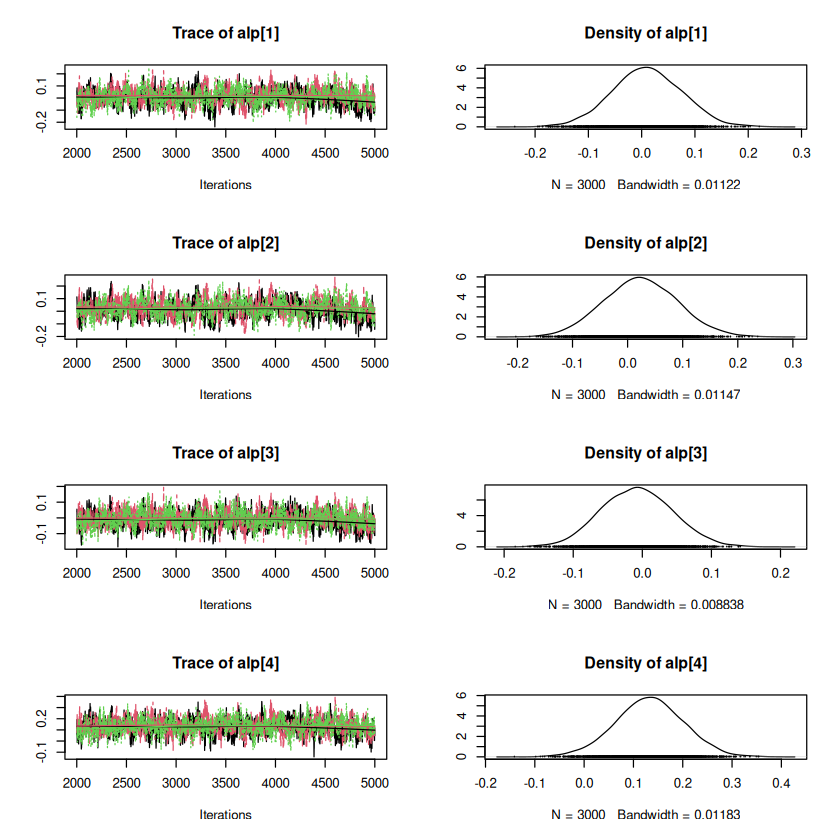

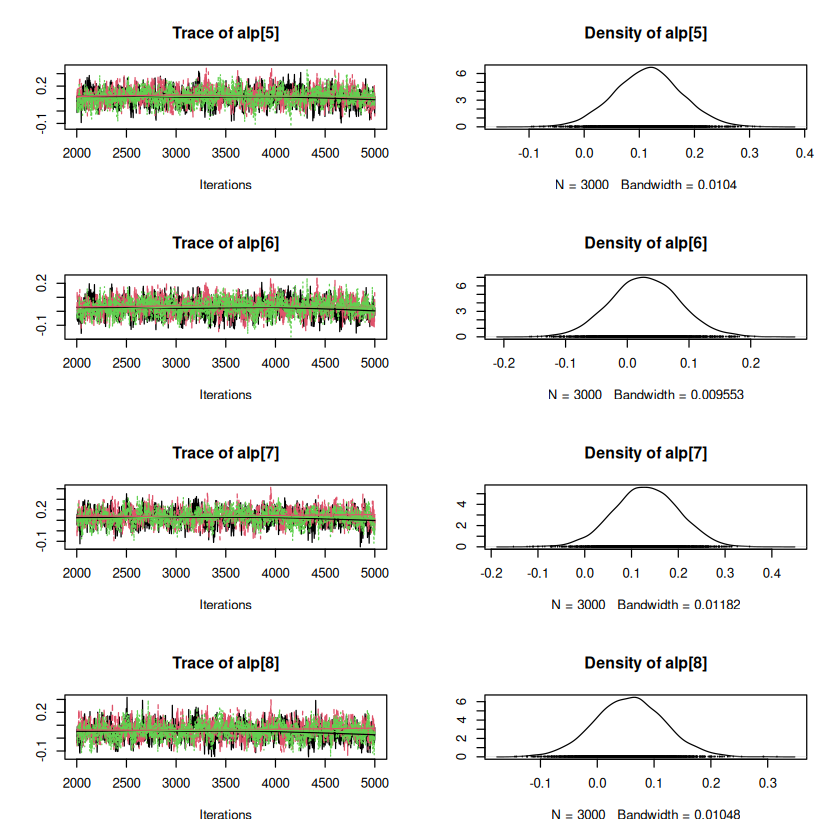

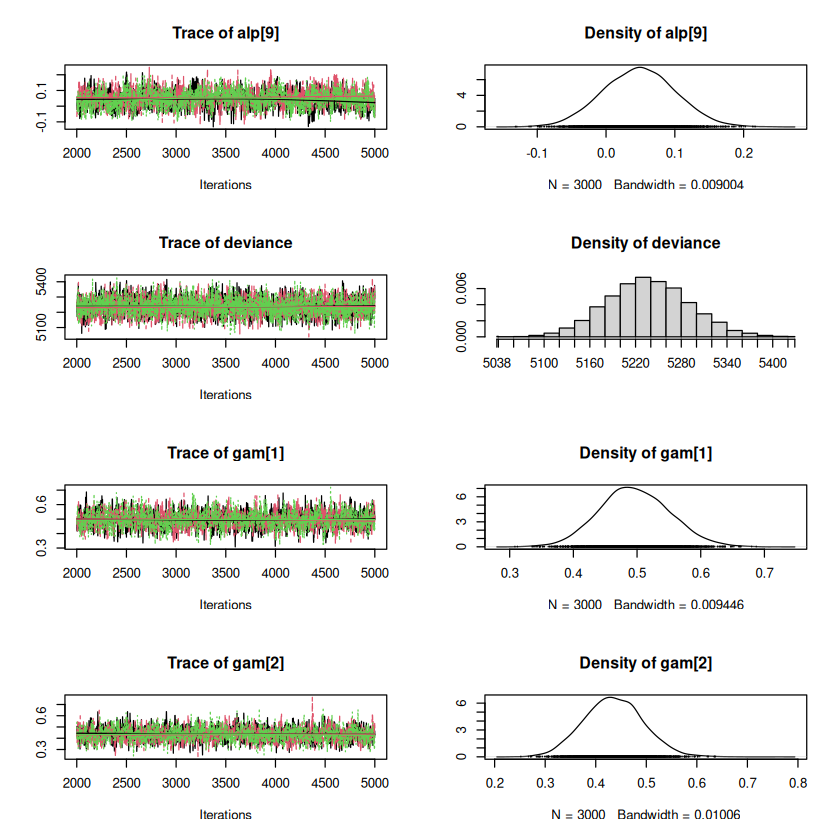

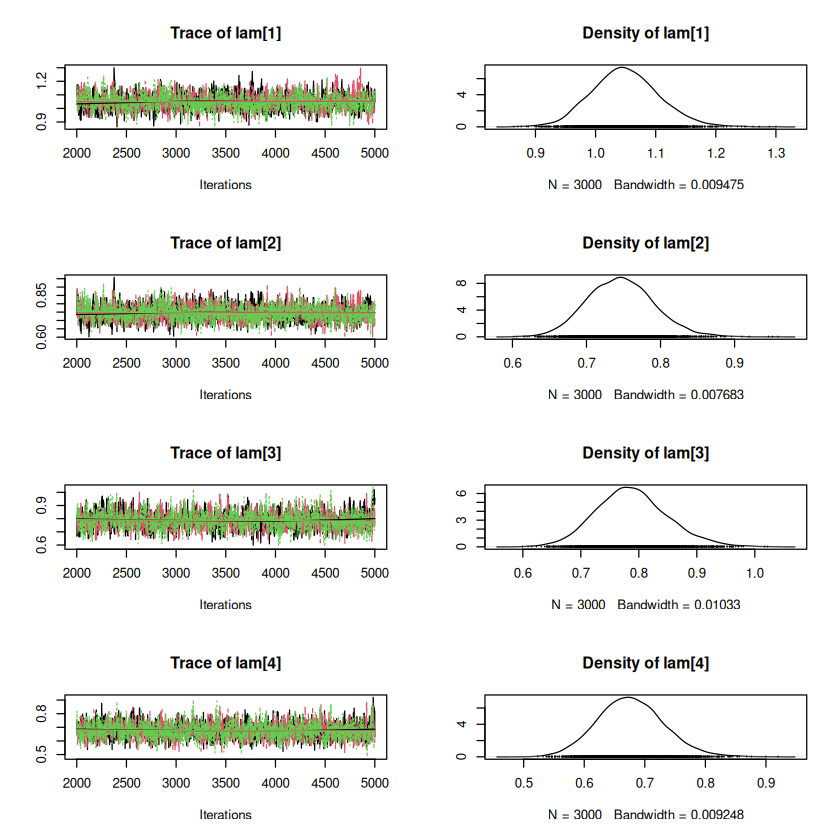

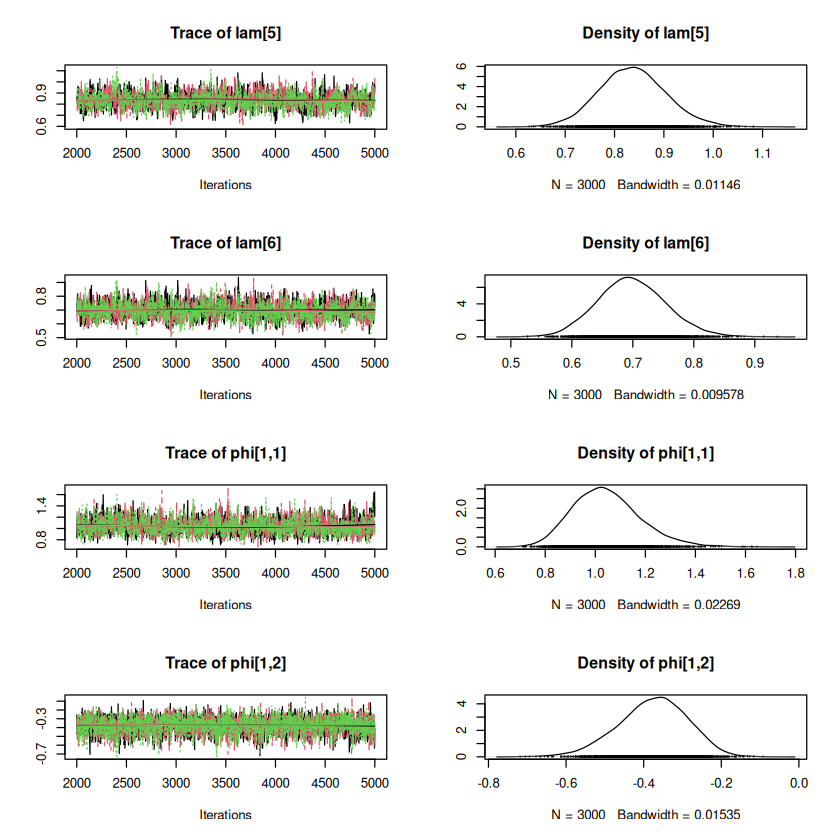

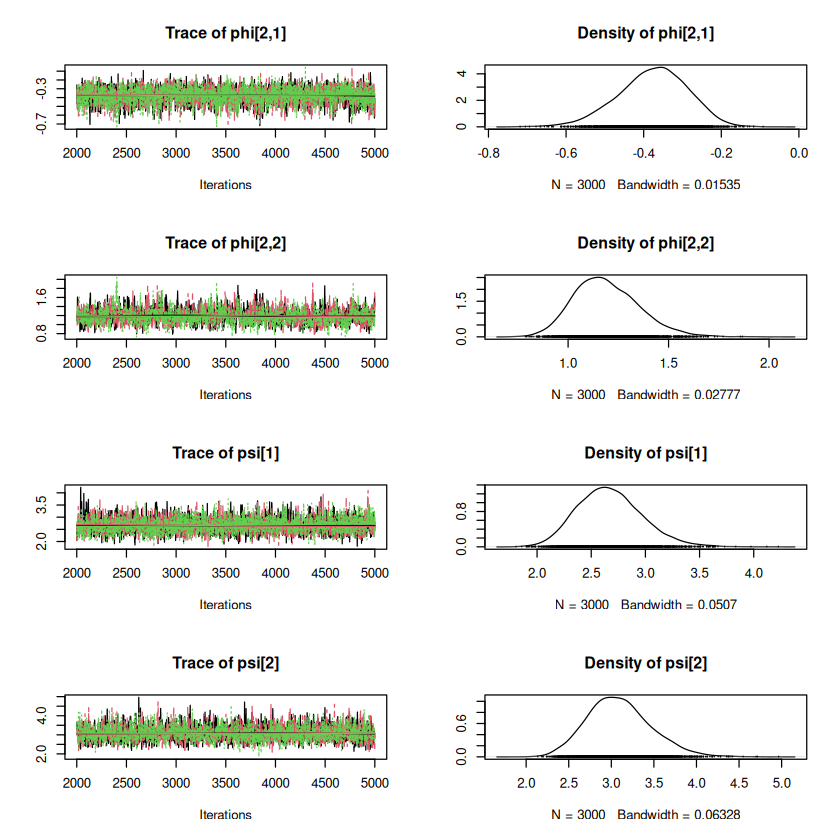

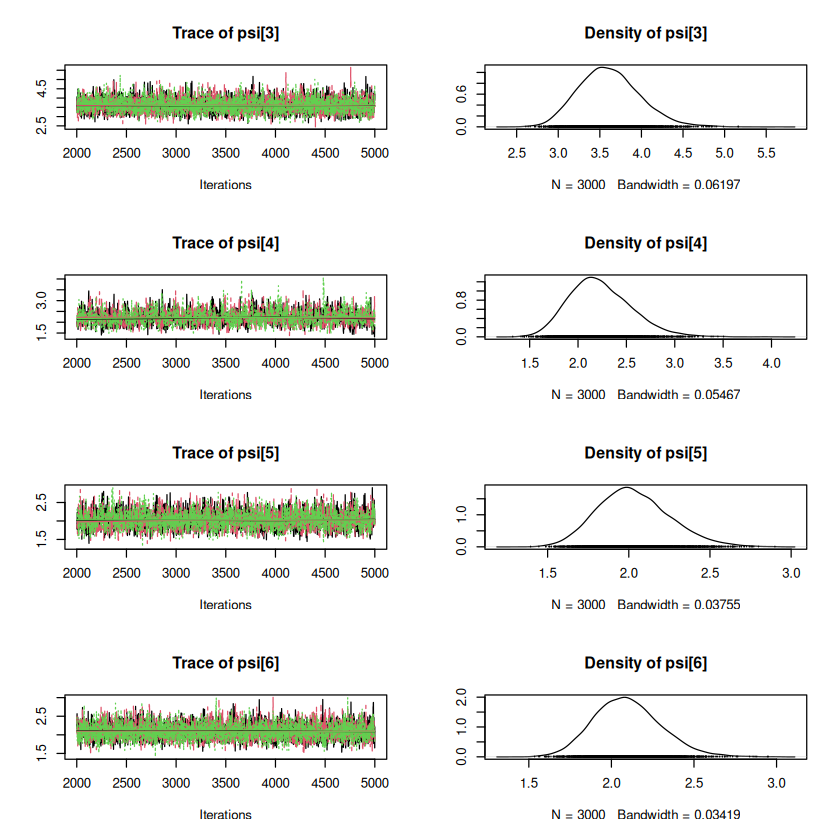

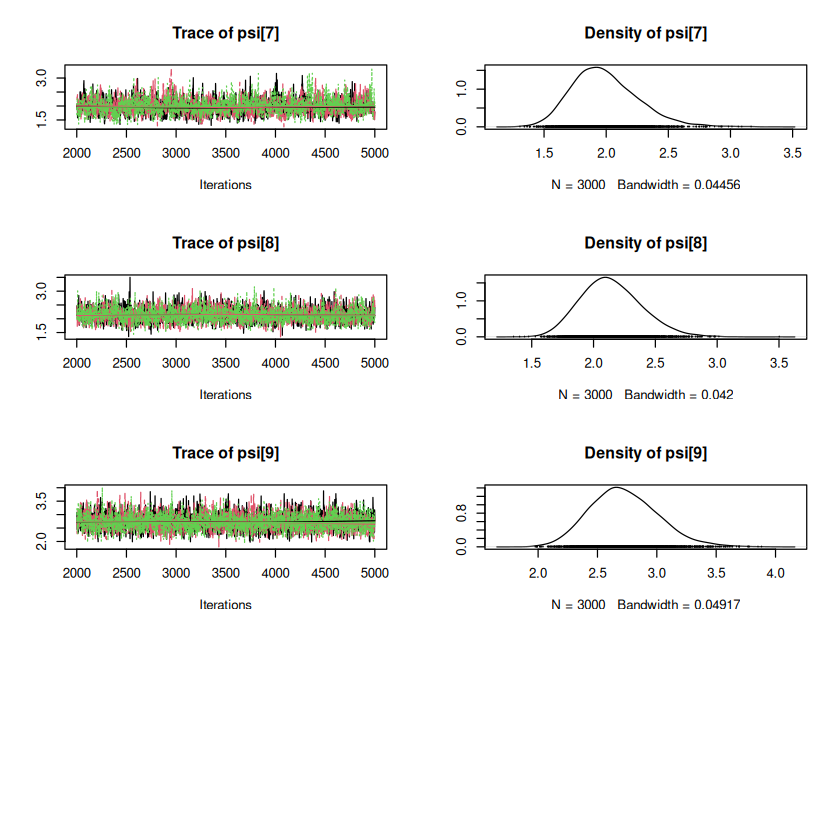

In [ ]:
codaobject <- read.bugs(model.out)
plot(codaobject)
save.image()

##### Step 4: Obtain Bayesian statistics

To get estimates for omega_i, i.e. node `xi` (which was omitted in step 1), re-run `bugs()` with  the `parameters.to.save` updated, additional iterations (for example, 4000 or 5000) and `codaPkg = FALSE`. Note that the output results are displayed by a column vector (`xi[1,1],xi[1,2],xi[1,3],xi[2,1],xi[2,2],xi[2,3],......,xi[100,1],xi[100,2],xi[100,3]`)

The results for statistics inference, for example, the mean (the Bayesian estimates), standard deviation, Monte Carlo error, will be given in the output of `bugs()` and in the log file. To get the corresponding DIC values, set bugs()' argument `DIC = TRUE` (default).

In [ ]:
model.out <- bugs(
    data, 
    inits, 
    param, 
    model.file = model, 
    2*n.iter, 
    n.burnin = n.burnin, 
    codaPkg = FALSE,  # Get bugs object
    working.directory = paste0(getwd(), "/Chapter4/bugs-output")
)
model.out
save.image()

Inference for Bugs model at "/tmp/RtmpDvLw2R/modeld67fe67045a3a.txt", 
Current: 3 chains, each with 10000 iterations (first 2000 discarded)
Cumulative: n.sims = 24000 iterations saved
            mean   sd   2.5%    25%    50%    75%  97.5% Rhat n.eff
alp[1]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1  3000
alp[2]       0.0  0.1   -0.1    0.0    0.0    0.1    0.2    1  4200
alp[3]       0.0  0.1   -0.1    0.0    0.0    0.0    0.1    1  3000
alp[4]       0.1  0.1    0.0    0.1    0.1    0.2    0.3    1  2100
alp[5]       0.1  0.1    0.0    0.1    0.1    0.2    0.2    1  9200
alp[6]       0.0  0.1   -0.1    0.0    0.0    0.1    0.1    1 24000
alp[7]       0.1  0.1    0.0    0.1    0.1    0.2    0.3    1  2000
alp[8]       0.1  0.1   -0.1    0.0    0.1    0.1    0.2    1  1800
alp[9]       0.0  0.1   -0.1    0.0    0.0    0.1    0.2    1  2000
lam[1]       1.0  0.1    0.9    1.0    1.0    1.1    1.2    1 24000
lam[2]       0.7  0.0    0.7    0.7    0.7    0.8    0.8    1 24000


In [ ]:
model.out <- R2WinBUGS::bugs(
    data, 
    inits, 
    param, 
    model.file = model,
    n.iter = 2*n.iter,
    n.burnin = n.burnin,
    n.thin = 1,
    debug = FALSE,
    codaPkg = FALSE,
    bugs.directory = paste0(Sys.getenv("HOME"), "/.wine/drive_c/Program Files (x86)/WinBUGS14/"),
    program = "WinBUGS",
    working.directory = paste0(getwd(), "/Chapter6/bugs-output"),
    WINE = "/usr/bin/wine",
    WINEPATH = "/usr/bin/winepath"
)


In [ ]:
model.out

[1] "/home/pal_bjartan/Backup/PhD/SEM-test-model/Lee2007/Chapter6/bugs-output/coda1.txt"
[2] "/home/pal_bjartan/Backup/PhD/SEM-test-model/Lee2007/Chapter6/bugs-output/coda2.txt"
[3] "/home/pal_bjartan/Backup/PhD/SEM-test-model/Lee2007/Chapter6/bugs-output/coda3.txt"

#### JAGS

##### Convergence

In [14]:
model

[1] "/home/pal_bjartan/Backup/PhD/SEM-test-model/Lee2007/Chapter4/ch4-R2OpenBUGS-model.txt"

In [18]:
model.jags <- rjags::jags.model(
    model,
    data,
    inits,
    n.chains = 2,
    n.adapt = burnin
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2700
   Unobserved stochastic nodes: 628
   Total graph size: 12356

Initializing model



In [10]:
iter

[1] 5000

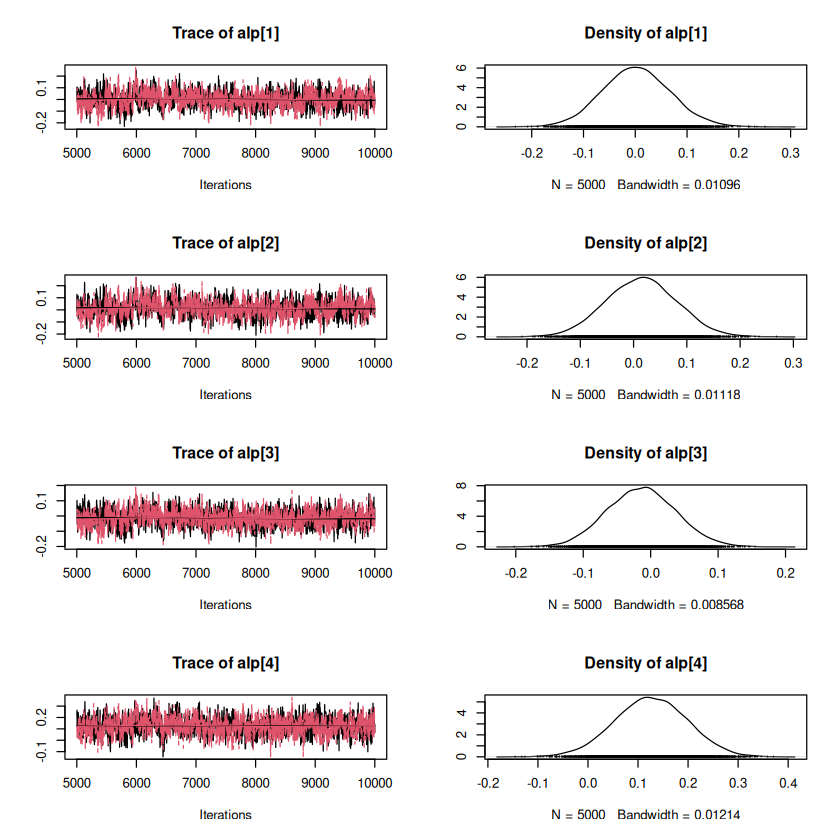

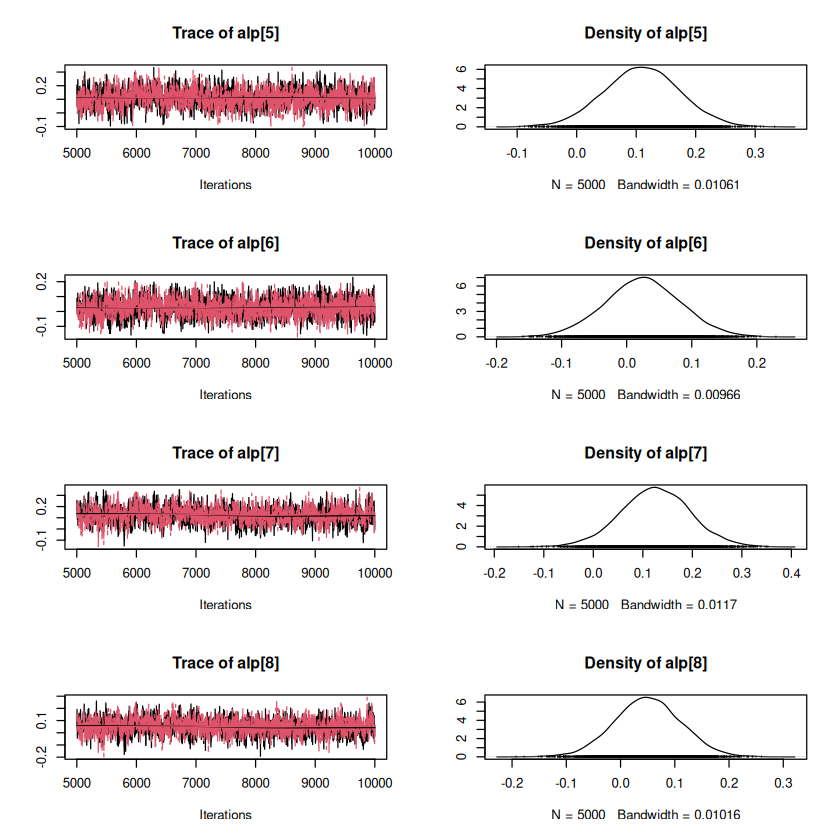

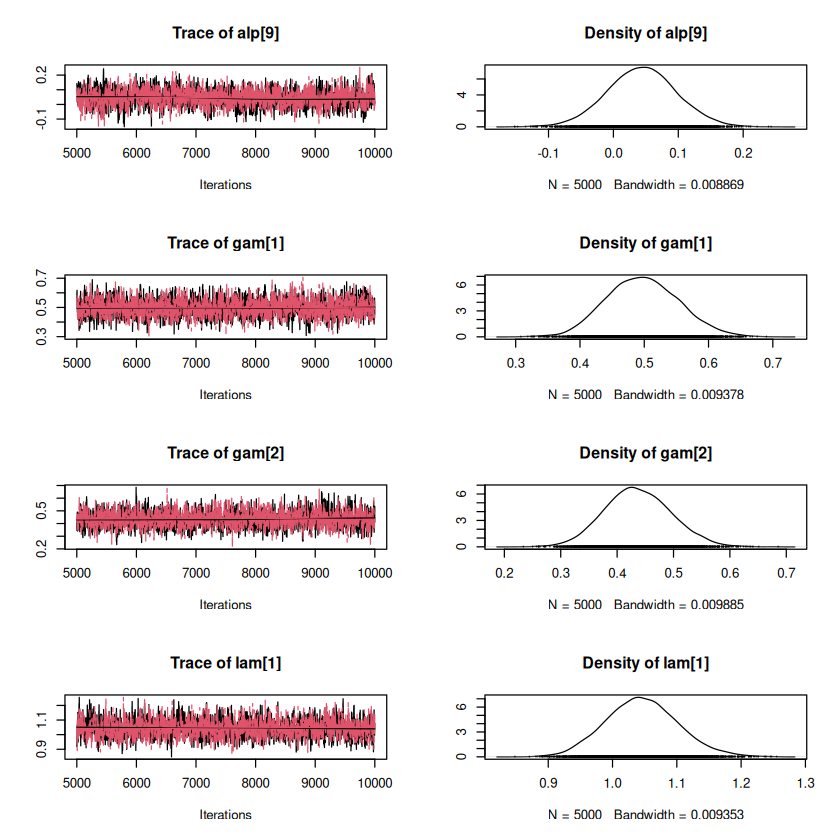

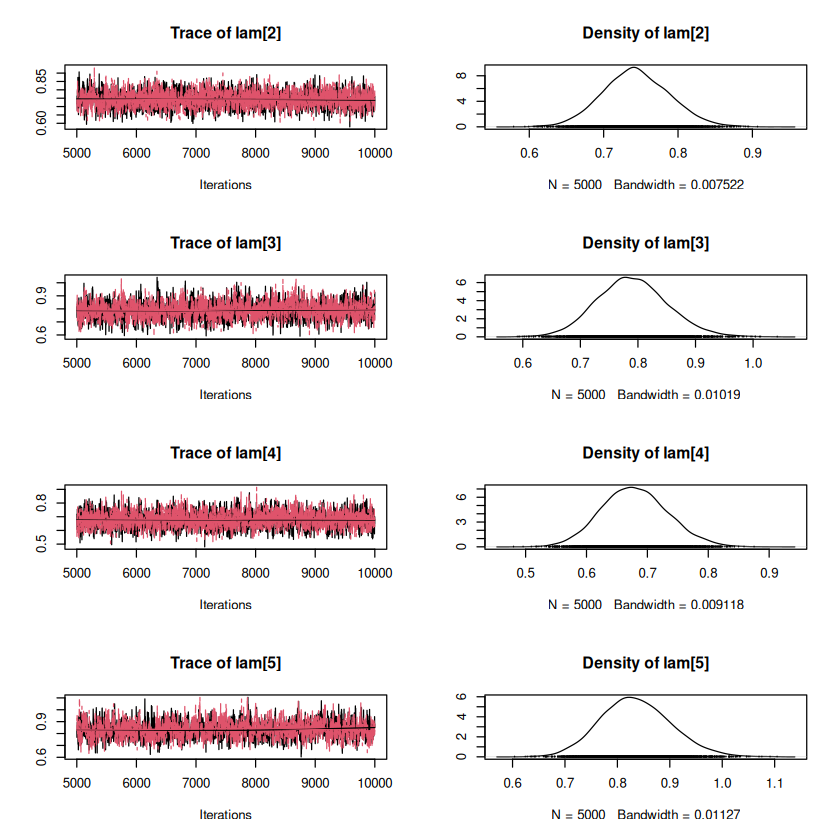

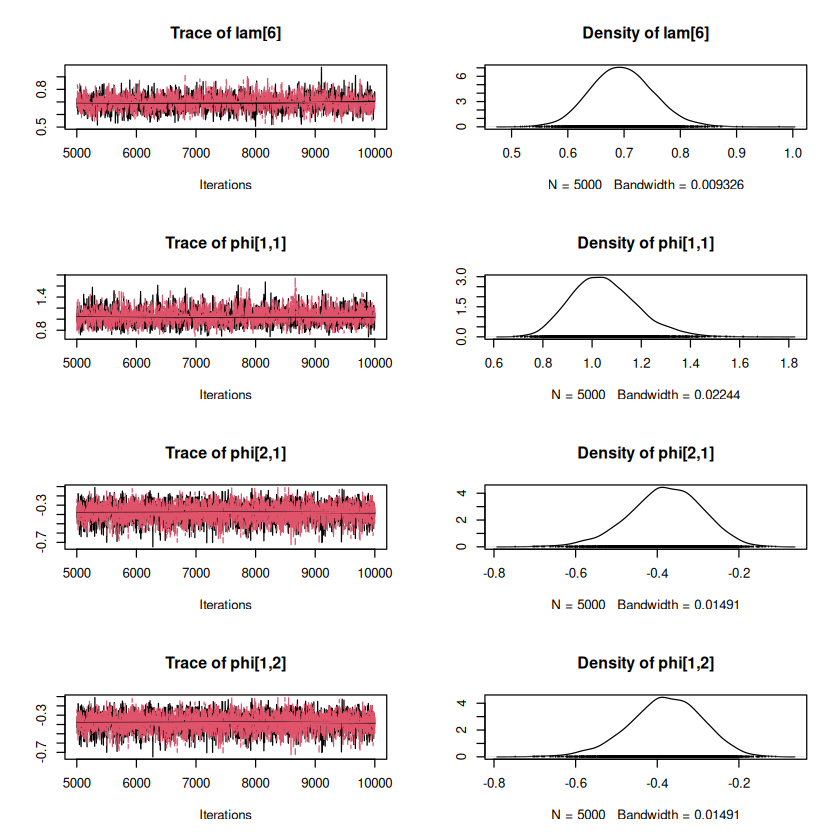

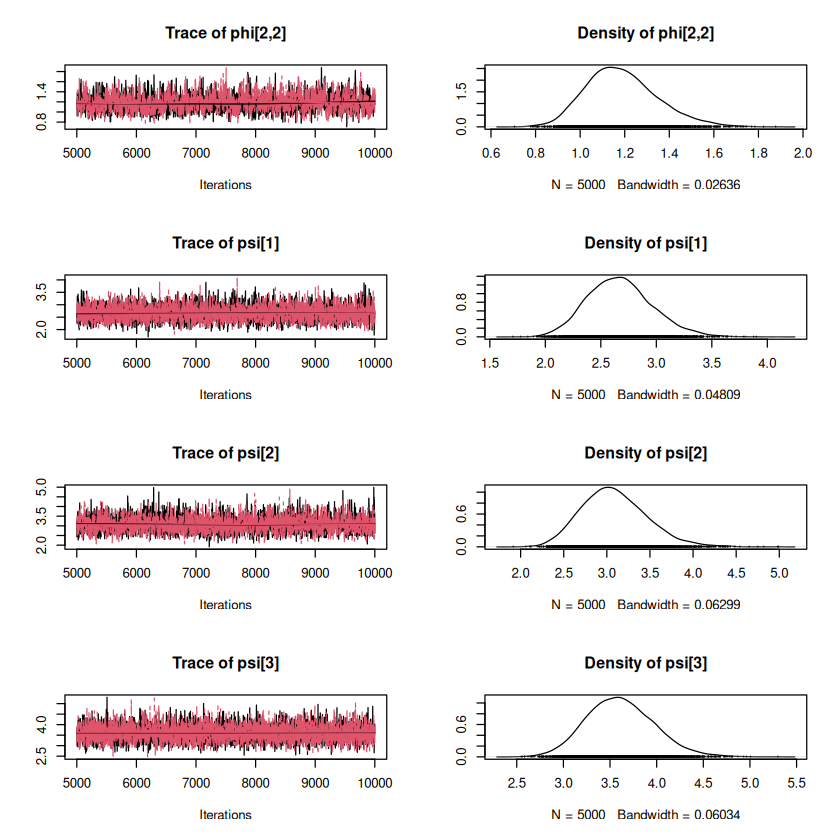

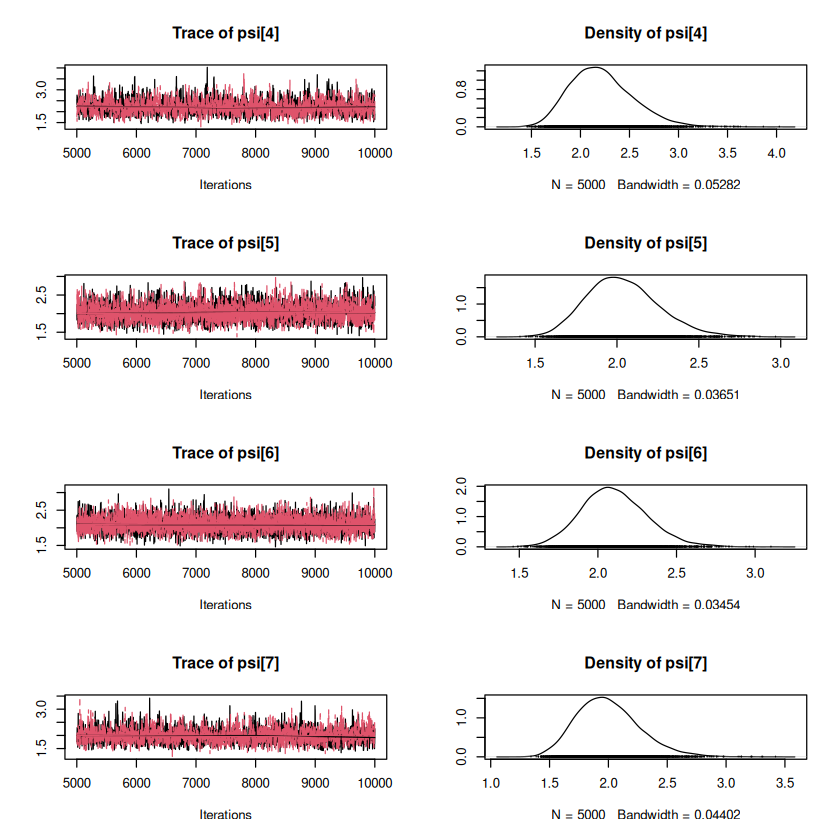

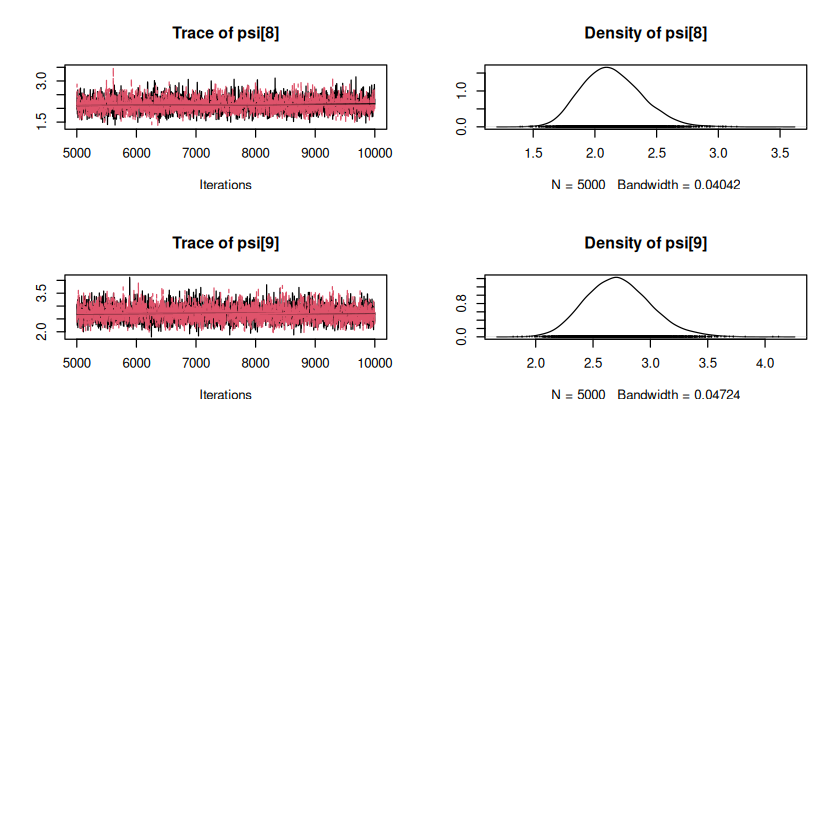

In [20]:
coda.jags <- rjags::coda.samples(
    model.jags,
    param[-6],
    iter
)

plot(coda.jags)

##### Obtain Bayesian Statistics

In [22]:
fit.jags  <- rjags::jags.samples(
    model.jags,
    param,
    2*iter
)
fit.jags

$alp
mcarray:
[1]  0.002007535  0.014749819 -0.014215256  0.126273911  0.110122366  0.024917569  0.126265709  0.051466111  0.043757110

Marginalizing over: iteration(10000),chain(2) 

$gam
mcarray:
[1] 0.4957764 0.4357303

Marginalizing over: iteration(10000),chain(2) 

$lam
mcarray:
[1] 1.0506274 0.7466352 0.7912702 0.6804164 0.8368029 0.6973796

Marginalizing over: iteration(10000),chain(2) 

$phi
mcarray:
           [,1]       [,2]
[1,]  1.0495413 -0.3779981
[2,] -0.3779981  1.1877258

Marginalizing over: iteration(10000),chain(2) 

$psi
mcarray:
[1] 2.661785 3.090569 3.620482 2.210016 2.036866 2.101837 1.991804 2.144127 2.721722

Marginalizing over: iteration(10000),chain(2) 

$xi
mcarray:
               [,1]         [,2]
  [1,]  0.381402433 -0.782000502
  [2,]  1.381701218  0.360114049
  [3,]  1.364868099  0.614022868
  [4,] -0.112612957 -0.019071702
  [5,] -1.293881390  0.393233334
  [6,]  0.170356505  0.052407573
  [7,]  0.452409701 -0.204963608
  [8,] -0.009643750 -1.148317753


In [ ]:
save(
    coda, fit, 
    file = glue("{getwd()}/Chapter6/model-fit.Rdata")
)

#### Nimble

In [23]:
library(nimble)

nimble version 1.0.1 is loaded.
For more information on NIMBLE and a User Manual,
please visit https://R-nimble.org.

Note for advanced users who have written their own MCMC samplers:
  As of version 0.13.0, NIMBLE's protocol for handling posterior
  predictive nodes has changed in a way that could affect user-defined
  samplers in some situations. Please see Section 15.5.1 of the User Manual.


Attaching package: ‘nimble’


The following object is masked from ‘package:boot’:

    logit


The following object is masked from ‘package:stats’:

    simulate




In [174]:
inits.nim <- lapply(1, function(x) inits()) %>% .[[1]]

List of 6
 $ alp: num [1:9] 2 2 2 2 2 2 2 2 2
 $ lam: num [1:6] 1 0.3 0.4 0.5 1 -1
 $ psi: num [1:9] 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 $ psd: num 0.3
 $ gam: num [1:2] 2 2
 $ phi: num [1:2, 1:2] 0.9 0.3 0.3 0.8


In [175]:
# model.nim  <- str2lang( "{
#     for(i in 1:N){
#         #measurement equation model
#         for(j in 1:P){
#             y[i,j] ~ dnorm(mu[i,j],psi[j])
#             ephat[i,j] <- y[i,j] - mu[i,j]
#         }
#         mu[i,1] <- eta[i]+alp[1]
#         mu[i,2] <- lam[1] * eta[i] + alp[2]
#         mu[i,3] <- lam[2] * eta[i] + alp[3]
#         mu[i,4] <- xi[i,1] + alp[4]
#         mu[i,5] <- lam[3] * xi[i,1] + alp[5]
#         mu[i,6] <- lam[4] * xi[i,1] + alp[6]
#         mu[i,7] <- xi[i,2] + alp[7]
#         mu[i,8] <- lam[5] * xi[i,2] + alp[8]
#         mu[i,9] <- lam[6] * xi[i,2] + alp[9]

#         #structural equation model
#         xi[i,1:2] ~ dmnorm(u[1:2], phi[1:2,1:2])
#         eta[i] ~ dnorm(nu[i], psd)
#         nu[i] <- gam[1] * xi[i,1] + gam[2] * xi[i,2]
#         dthat[i] <- eta[i] - nu[i]
#     } #end of i

#     #priors on intercepts
#     for(j in 1:9){alp[j]~dnorm(0.0, 1.0)}

#     #priors on loadings and coefficients
#     lam[1] ~ dnorm(0.8, psi[2])
#     lam[2] ~ dnorm(0.8, psi[3])
#     lam[3] ~ dnorm(0.8, psi[5])
#     lam[4] ~ dnorm(0.8, psi[6])
#     lam[5] ~ dnorm(0.8, psi[8])
#     lam[6] ~ dnorm(0.8, psi[9])
#     for(j in 1:2){ gam[j] ~ dnorm(0.5, psd) }
    
#     #priors on precisions
#     for(j in 1:P){
#         psi[j] ~ dgamma(9.0, 4.0)
#         sgm[j] <- 1/psi[j]
#     }
#     psd ~ dgamma(9.0, 4.0)
#     sgd <- 1/psd
#     phi[1:2,1:2] ~ dwish(R[1:2,1:2], 5)
#     phx[1:2,1:2] <- inverse(phi[1:2, 1:2])

# }" ) # end of model

In [165]:
# model.nim <- nimbleModel(
#     model.nim,
#     constants = data[1:2],
#     data = data[3:5],
#     inits = inits.nim,
#     calculate = TRUE
# )

Defining model

Building model

Setting data and initial values

Running calculate on model
  [Note] Any error reports that follow may simply reflect missing values in model variables.

Checking model sizes and dimensions

  [Note] This model is not fully initialized. This is not an error.
         To see which variables are not initialized, use model$initializeInfo().
         For more information on model initialization, see help(modelInitialization).



In [181]:
model.nim <- readBUGSmodel(
    model,
    data = data,
    inits = lapply(1, function(x) inits()) %>% .[[1]]
)

Defining model

  [Note] Using 'y' (given within 'constants') as data.

Building model

Setting data and initial values

Checking model sizes and dimensions

  [Note] This model is not fully initialized. This is not an error.
         To see which variables are not initialized, use model$initializeInfo().
         For more information on model initialization, see help(modelInitialization).



In [223]:
chains

ERROR: Error in eval(expr, envir, enclos): object 'chains' not found


In [224]:
model.nim.out <- nimbleMCMC(
    inits = inits,
    model = model.nim, 
    monitors = param, 
    niter = 2*iter,
    nburnin = burnin,
    nchains = 3
)

Compiling
  [Note] This may take a minute.
  [Note] Use 'showCompilerOutput = TRUE' to see C++ compilation details.

running chain 1...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


running chain 2...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


running chain 3...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


In [230]:
lapply(model.nim.out, function(x) {
as.data.frame(summary(x)) %>%
select(-"Var1") %>%
separate_wider_delim(Freq, ":", names_sep = "") %>%
pivot_wider(names_from = Freq1, values_from = Freq2)
})

Var2,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
alp[1],-0.225402,-0.039263,0.005338,0.005640,0.050450,0.246996
alp[2],-0.24138,-0.02694,0.01815,0.01862,0.06571,0.29161
alp[3],-0.21643,-0.04751,-0.01192,-0.01195,0.02299,0.19456
alp[4],-0.12615,0.08032,0.12943,0.12834,0.17714,0.39965
alp[5],-0.10860,0.07016,0.11131,0.11180,0.15401,0.32907
alp[6],-0.17911,-0.01186,0.02571,0.02570,0.06437,0.24713
alp[7],-0.12592,0.08428,0.13170,0.13073,0.17773,0.36980
alp[8],-0.19526,0.01489,0.05687,0.05548,0.09734,0.27547
alp[9],-0.14331,0.01267,0.04694,0.04679,0.08281,0.21966


In [170]:
model.nim$simulate()

In [171]:
model.nim$calculate()

[1] -14182.41

In [172]:
param.est <- lapply(param, function (x) model.nim[[x]])
names(param.est) <- param
param.est

4.088656,3.993820
3.993820,5.514233
-0.1974720148,-0.199552112
1.2453664400,-0.329275265
0.6589320852,-0.078707610
-1.7939209116,0.817583382
-0.0595883674,-0.272889213
0.1258774360,0.155408369
2.2247249028,-2.021038086
0.5164880210,-0.593239670
0.8827486767,-0.782509741
